## Introduction to FAISS (Pinecone/James Briggs course)

In [1]:
import requests
import os

In [2]:
data_url = "https://raw.githubusercontent.com/jamescalam/data/main/sentence_embeddings_15K/"

In [ ]:
if not os.path.exists('../../data/data_faiss_intro'):
    os.mkdir('../../data/data_faiss_intro')

for i in range(57):
#     if i < 10:
#         i = '0' + str(i)
    res = requests.get(data_url+f"embeddings_{i}.npy")
    with open(f'../../data/data_faiss_intro/embeddings_{i}.npy', 'wb') as fp:
        for chunk in res:
            fp.write(chunk)
    print('.', end='')

In [ ]:
res = requests.get(f"{data_url}sentences.txt")
with open(f"../../data/data_faiss_intro/sentences.txt", 'wb') as fp:
    for chunk in res:
        fp.write(chunk)

In [2]:
import numpy as np

In [3]:
for i  in range(57):
    if i == 0:
        with open(f'../../data/data_faiss_intro/embeddings_{i}.npy', 'rb') as fp:
            sentence_embedding = np.load(fp)
    else:
        with open(f'../../data/data_faiss_intro/embeddings_{i}.npy', 'rb') as fp:
            sentence_embedding = np.append(
                sentence_embedding, 
                np.load(fp), axis=0
            )      

In [4]:
sentence_embedding.shape

(14504, 768)

In [5]:
with open('../../data/data_faiss_intro/sentences.txt', 'r') as fp:
    lines = fp.read().split('\n')

In [6]:
lines[:5]

['A group of four children dancing in a backyard.',
 'The Conference Board said its measure of business confidence, which had fallen to 53 in the first quarter of 2003, improved to 60 in the most recent second quarter.',
 'a person eating a meal, often in a restaurant',
 'When you crossed the line, you violated the constitutional right," said Charles Weisselberg, who teaches law at the University of California, Berkeley.',
 "Ross Garber, Rowland's legal counsel, said the governor would have no comment on the condo deal."]

In [3]:
from sentence_transformers import SentenceTransformer

In [8]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [9]:
# model.encode(['Hello wolrd'], device='cuda', show_progress_bar=True)

In [4]:
import faiss

## Index using FlatL2

In [12]:
#IndexFlatL2 (eulidean distance)
d = sentence_embedding.shape[1]

In [111]:
index_fl2 = faiss.IndexFlatL2(d) # define index type
res = faiss.StandardGpuResources()  # use a single GPU

# make it into a gpu index
gpu_index_fl2 = faiss.index_cpu_to_gpu(res, 0, index_fl2)


In [112]:
gpu_index_fl2.is_trained

True

In [113]:
gpu_index_fl2.add(sentence_embedding)

In [114]:
gpu_index_fl2.ntotal

14504

In [21]:
xq = model.encode(['someone sprints with a football'], device = 'cuda')

In [22]:
k = 4 # similar vectors number

In [121]:
%%time
D, I = gpu_index_fl2.search(xq, k)
print(I)

[[ 4586 10252 12465   190]]
CPU times: user 5.94 ms, sys: 11.7 ms, total: 17.6 ms
Wall time: 11.8 ms


In [122]:
[f'{i}: {lines[i]}' for i in I[0]]

['4586: A group of football players is running in the field',
 '10252: A group of people playing football is running in the field',
 '12465: Two groups of people are playing football',
 '190: A person playing football is running past an official carrying a football']

## Partitioning indexing using IVFFlat

Approximate searching 

In [123]:
nlist = 50 # number of cells or voronoi poligons

# Flat L2 Index
index = faiss.IndexFlatL2(d)

res = faiss.StandardGpuResources()  # use a single GPU
# make it into a gpu index and takenir
quantizer = faiss.index_cpu_to_gpu(res, 0, index)

gpu_index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist)

In [126]:
gpu_index_ivf.is_trained

False

In [127]:
# we need to train our index
gpu_index_ivf.train(sentence_embedding)

In [128]:
gpu_index_ivf.is_trained

True

In [129]:
gpu_index_ivf.add(sentence_embedding)
gpu_index_ivf.ntotal

14504

In [132]:
%%time
D, I = gpu_index_ivf.search(xq, k)
print(I)

[[ 4586 10252 12465   190]]
CPU times: user 10.5 ms, sys: 1.97 ms, total: 12.5 ms
Wall time: 6.44 ms


In [133]:
[f'{i}: {lines[i]}' for i in I[0]]

['4586: A group of football players is running in the field',
 '10252: A group of people playing football is running in the field',
 '12465: Two groups of people are playing football',
 '190: A person playing football is running past an official carrying a football']

In [134]:
# change nprobe to improve better results but with less speed
gpu_index_ivf.nprobe = 10

In [136]:
%%time
D, I = gpu_index_ivf.search(xq, k)
print(I)

[[ 4586 10252 12465   190]]
CPU times: user 13.9 ms, sys: 18 ms, total: 31.9 ms
Wall time: 21.7 ms


In [137]:
[f'{i}: {lines[i]}' for i in I[0]]

['4586: A group of football players is running in the field',
 '10252: A group of people playing football is running in the field',
 '12465: Two groups of people are playing football',
 '190: A person playing football is running past an official carrying a football']

## Product quantization index

Faster but with with less precision. 

Split the original vector in n sub-vectors. Run a cluster algorithm for every sub-vector. Search the similar cluster and search the result inside the sub-vector that corresponds the cluster.

**Important note: due to use a lot of ```faiss.index_cpu_to_gpu``` I need to reestart my notebook. Be careful of how too use the cpu yo gpu indexing because you can full the gpu memory**

In [13]:
# firs we need to see if we can divide the centroid
# d need to be a multiple of m
d % 8

0

In [14]:
nlist = 50 # number of cells

m = 8 # number of centroids in the final vector
bits = 8 # number of bits inside that vector

# quantizer Flat L2 Index
index = faiss.IndexFlatL2(d)

res = faiss.StandardGpuResources()  # use a single GPU
# make it into a gpu index and takenir
quantizer = faiss.index_cpu_to_gpu(res, 0, index)

gpu_index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) # reduce the size using this method

In [16]:
gpu_index_ivfpq.is_trained

False

In [17]:
gpu_index_ivfpq.train(sentence_embedding)

In [18]:
gpu_index_ivfpq.is_trained

True

In [19]:
gpu_index_ivfpq.add(sentence_embedding)
gpu_index_ivfpq.ntotal

14504

In [24]:
%%time
D, I = gpu_index_ivfpq.search(xq, k)
print(I)

[[  399  8328 12465   190]]
CPU times: user 5.86 ms, sys: 8.28 ms, total: 14.1 ms
Wall time: 7.39 ms


In [25]:
[f'{i}: {lines[i]}' for i in I[0]]

['399: A football player kicks the ball.',
 '8328: A football player is running past an official carrying a football',
 '12465: Two groups of people are playing football',
 '190: A person playing football is running past an official carrying a football']

## Speed improvement with syntethic data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

In [6]:
colors = ['#041BB3', '#E31957', '#12B0A7', '#000000']
sns.set_palette(sns.color_palette(colors))
sns.set_theme(font_scale=1.4)

In [7]:
def make_array(nb, d=100):
    return np.random.random((nb, d)).astype('float32')

In [8]:
def test(index, step=1_000, high=1_000_000, k=5, epochs=20):
    timer = np.zeros((epochs, int(high/step)))
    dim = np.zeros((int(high/step)))
    xq = make_array(1)
    for epoch in tqdm(range(epochs)):
        index.reset()
        iter_step = 0
        for i in range(step, high, step):
            wb = make_array(step)
            if not index.is_trained:
                index.train(wb)
            index.add(wb)
            # start timer
            start = datetime.now()
            D,I = index.search(xq, k)
            time_taken = (datetime.now() - start).microseconds
            timer[epoch, iter_step] = time_taken
            dim[iter_step] = i
            iter_step += 1
    timer = np.median(timer, axis=0)
    return dim, timer

In [9]:
d = 100
tests = pd.DataFrame({
    'num_vectors' : [],
    'query_time': [],
    'test': []
})


In [10]:
# Flat L2 Index
index = faiss.IndexFlatL2(d)

In [11]:
res = faiss.StandardGpuResources()  # use a single GPU
# make it into a gpu index
gpu_index = faiss.index_cpu_to_gpu(res, 0, index)

In [98]:
%%time
# test with GPU faiss time
dim, time = test(gpu_index,step=1_000, high=100_000, k=5, epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.13s/it]

CPU times: user 17.1 s, sys: 1.33 s, total: 18.4 s
Wall time: 22.7 s


In [99]:
%%time
# test with CPU faiss 
dim, time = test(index,step=1_000, high=100_000, k=5, epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.31s/it]

CPU times: user 45.9 s, sys: 395 ms, total: 46.3 s
Wall time: 46.1 s


In [12]:
# continuation of the example with GPU (faster) IndexFlat
dim, time = test(gpu_index)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [11:00<00:00, 33.05s/it]


In [13]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'FlatL2'
tests = tests.append(df, ignore_index=True)

In [14]:
# IVFFlat

nlist = 50 # number of cells or voronoi poligons

gpu_index_ivf = faiss.IndexIVFFlat(gpu_index, d, nlist)

In [18]:
gpu_index_ivf.nprobe

1

In [15]:
dim, time = test(gpu_index_ivf)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [08:57<00:00, 26.88s/it]


In [16]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'IVFFlat'
tests = tests.append(df, ignore_index=True)

In [36]:
d%5

0

In [41]:
# IVFPQ

nlist = 20 # number of cells

m = 10 # number of centroids in the final vector
bits = 4 # number of bits inside that vector

gpu_index_ivfpq = faiss.IndexIVFPQ(gpu_index, d, nlist, m, bits) # reduce the size using this method

In [42]:
gpu_index_ivfpq

<faiss.swigfaiss.IndexIVFPQ; proxy of <Swig Object of type 'faiss::IndexIVFPQ *' at 0x7f55d8cba780> >

In [40]:
dim, time = test(gpu_index_ivfpq)

  0%|                                                                                            | 0/20 [07:28<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'IVFPQ'
tests = tests.append(df, ignore_index=True)

Text(0, 0.5, 'query time (ms)')

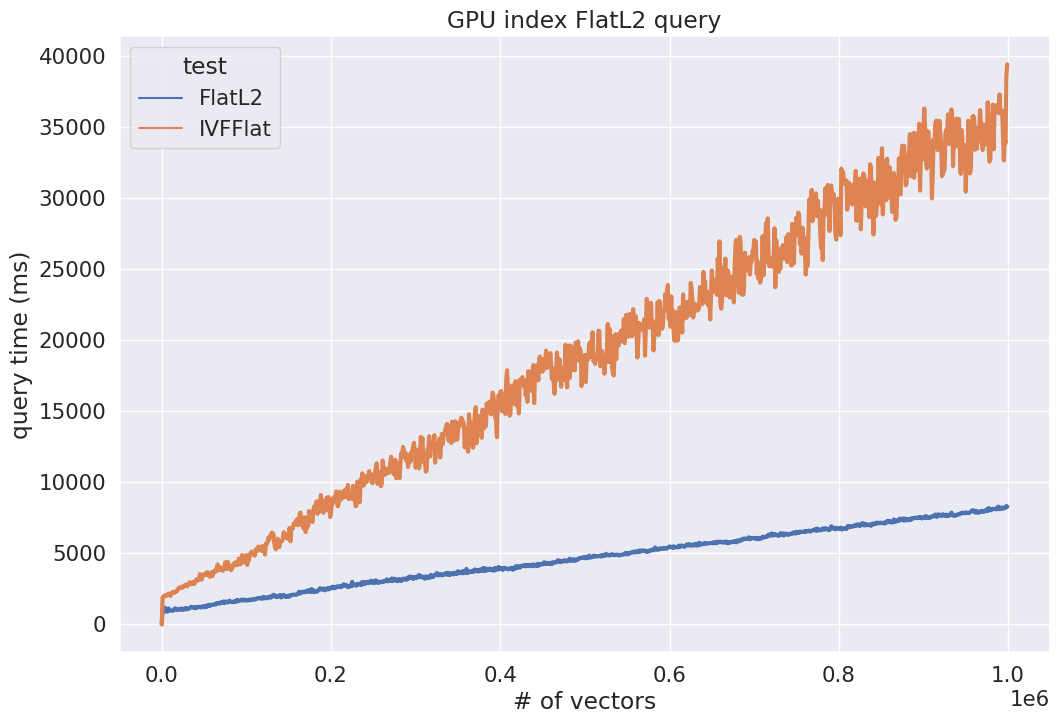

In [43]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(x='num_vectors', y='query_time', 
                  data=tests,
                  hue='test',
                  linewidth = 3)
ax.set_title('GPU index FlatL2 query')
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')